# Ethanol Data Augmentation

This notebook is a part of a ethanol fermentation soft sensor to predict ethanol and substrate concentrations. It utilizes the TSGM module, which is built on the TensorFlow framework, to perform data augmentations to expand the training set for a feed-forward neural network.

# Setup

In [ ]:
# initialize file system

from google.colab import drive
drive.mount('/content/drive')
%cd
%cd '/content/drive/MyDrive/Colab Notebooks/ethanol-sensor'
filepath = './Interpolated Data Fermentation VHG_055_41_51.xlsx'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/root
/content/drive/MyDrive/Colab Notebooks/ethanol-sensor


In [ ]:
!pip install tsgm

In [ ]:
#%load_ext autoreload
#%autoreload 2

import numpy as np
import sklearn
import copy
import joblib
import sklearn.model_selection
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.impute import KNNImputer

import tsgm


In [ ]:
## helper function to convert 3D np.ndarray to 2D pd.DataFrame

def flatten3D(X: np.ndarray, columns: list = ['temp', 'pH', 'redox', 'capac', 'xdb', 'trs', 'ethn', 'sample_num']) -> pd.DataFrame:
  n_samples, n_timesteps, n_columns = X.shape

  # create an index to keep track of generated experiments
  # an nd array with n_timesteps copies of each integer for each of n_samples
  # reshape into (-1, 1) where rows is automatically calculated and 1 column
  sample_ind = np.reshape(np.repeat(np.arange(n_samples), n_timesteps), (n_timesteps * n_samples, 1))

  # flatten generated samples to 2D array
  flatfile = np.reshape(X, (-1, n_columns))

  flatfile_indexed = pd.DataFrame(
      np.concatenate((flatfile, sample_ind), axis = 1),
      columns = columns)
  flatfile_indexed.sample_num = flatfile_indexed.sample_num.astype(int)

  return flatfile_indexed

# Data import and cleaning

In [ ]:
# import each sheet (one sheet corresponds to one experiment)
n_experiments = 11
sheets = np.empty(n_experiments, dtype=np.ndarray)

for i in range(n_experiments):
  sheet = pd.read_excel(filepath, sheet_name = i)
  # select columns: temp, pH, redox, capacitance, substrate, ethanol
  sheets[i] = sheet.iloc[:, [1,2,4,5,6,7,8]].to_numpy()


In [ ]:
# stacked ndarray cannot be ragged. Since samples at the beginning are noisy, we discard them, keeping the last n observations in each experiment
n = 500

sheets_slice = np.empty(n_experiments, dtype=np.ndarray)
for i in range(n_experiments):
  sheets_slice[i] = sheets[i][-n: , :]


# stack all arrays into a 3-d ndarray
timeseries = np.stack(sheets_slice)


In [ ]:
timeseries.shape

(11, 500, 7)

In [ ]:
# perform imputation for missing redox data in experiment 10 using KNN regression

# make a temporary flat file of the data
flat_imputation_temp = flatten3D(timeseries)

# run KNN imputation
imputer = KNNImputer(n_neighbors=9, weights = 'distance')
timeseries_imputed_flat = pd.DataFrame(
    imputer.fit_transform(flat_imputation_temp),
    columns = ['temp', 'pH', 'redox', 'capac', 'xdb', 'trs', 'ethn', 'sample_num'])

# save the imputed redox array
imputed_redox = timeseries_imputed_flat[timeseries_imputed_flat.sample_num == 9].redox

# create a new copy of the timeseries and replace the NANs with the imputed values
timeseries_imputed = timeseries
timeseries_imputed[9, :, 2] = imputed_redox



In [ ]:
# preview the shape
print(timeseries_imputed.shape)
with np.printoptions(threshold=2000, linewidth=10000, suppress = True):
    print(timeseries_imputed)

In [ ]:
tsscaler = tsgm.utils.TSFeatureWiseScaler()

# scaling has already been performed and state saved to disk.
# tsscaler.fit(timeseries_imputed)
# joblib.dump(tsscaler, './state_files/tsscaler.ts')

In [ ]:
# load scaler from disk
tsscaler = joblib.load('./state_files/tsscaler.ts')

# load scaled data from disk
timeseries_imputed_scaled = joblib.load('./state_files/timeseries_imputed_scaled.data')

In [ ]:
# save to disk (already done)
# joblib.dump(timeseries_imputed_scaled, './state_files/timeseries_imputed_scaled_real.data')

['./state_files/timeseries_imputed_scaled_real.data']

# Simple data augmentation

### Jittering/Gaussian noise

In [ ]:
n_samples = 100

aug_model = tsgm.models.augmentations.GaussianNoise()
samples = aug_model.generate(X=timeseries_imputed_scaled, n_samples=n_samples, variance=0.2)

In [ ]:
print(samples.shape)
with np.printoptions(threshold=2000, linewidth=10000, suppress = True):
    print(samples)

In [ ]:
joblib.dump(samples, './state_files/jittered_data_ndarray.data')

['./state_files/jittered_data_ndarray.data']

In [ ]:
jittered_data = flatten3D(samples)

In [ ]:
jittered_data

In [ ]:
jittered_data.to_csv('gaussian_augmented_data_v4.csv')

Note: v1 is the originally generated dataset, with experiment 10 dropped. v2 includes the imputed data as well as adding the feature for xdb (cell concentration). v3 is pre-scaled using the skscaler. v4 is pre-scaled using tsscaler.

# Deep learning approaches

### VAE approach

Note: this seems to only run on an A100 GPU in High-RAM mode (which requires Colab Pro). This architecture was probably not designed for a 500-timestep dataset.

Follow the code examples here: https://github.com/AlexanderVNikitin/tsgm/tree/main/tutorials


In [ ]:
# first argument is number of time steps (n), second argument is number of variables (7), third argument is the number of latent variables, and I used the default in the tutorial (10).
architecture = tsgm.models.zoo["vae_conv5"](n, 7, 10)
encoder, decoder = architecture.encoder, architecture.decoder

In [ ]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 500, 7)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 500, 64)              4544      ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 500, 64)              0         ['conv1d[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)           (None, 500, 64)              8256      ['dropout[0][0]']             
                                                                                            

In [ ]:
vae = tsgm.models.cvae.BetaVAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

history1 = vae.fit(timeseries_imputed_scaled, epochs=250, batch_size=16)


Epoch 1/250
1/1 [==============================] - 7s 7s/step - loss: 21.4664 - reconstruction_loss: 11.7518 - kl_loss: 9.7146
Epoch 2/250
1/1 [==============================] - 0s 90ms/step - loss: 294.1845 - reconstruction_loss: 285.5257 - kl_loss: 8.6589
Epoch 3/250
1/1 [==============================] - 0s 89ms/step - loss: 63.7073 - reconstruction_loss: 55.3445 - kl_loss: 8.3629
Epoch 4/250
1/1 [==============================] - 0s 88ms/step - loss: 162.5344 - reconstruction_loss: 153.6366 - kl_loss: 8.8979
Epoch 5/250
1/1 [==============================] - 0s 78ms/step - loss: 164.5211 - reconstruction_loss: 156.2100 - kl_loss: 8.3111
Epoch 6/250
1/1 [==============================] - 0s 73ms/step - loss: 63.3663 - reconstruction_loss: 55.7185 - kl_loss: 7.6477
Epoch 7/250
1/1 [==============================] - 0s 73ms/step - loss: 119.0979 - reconstruction_loss: 111.9018 - kl_loss: 7.1961
Epoch 8/250
1/1 [==============================] - 0s 72ms/step - loss: 152.4387 - reconstr

The plots below are from different runs of training. None of them are the actual plots from the training in the model that generated the data used in the regression models. The VAE doesn't seem to be converging properly - each run gives widely differing losses. Future investigation may involve looking at optimizing the VAE.

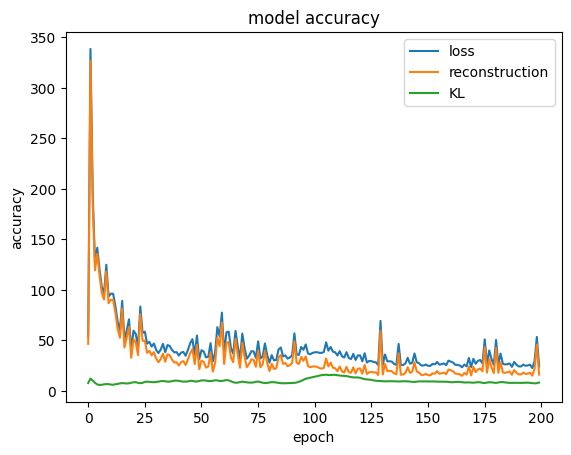

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history1.history['loss'])
plt.plot(history1.history['reconstruction_loss'])
plt.plot(history1.history['kl_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['loss', 'reconstruction', 'KL'])
plt.show()



Text(0.5, 0, 'epoch')

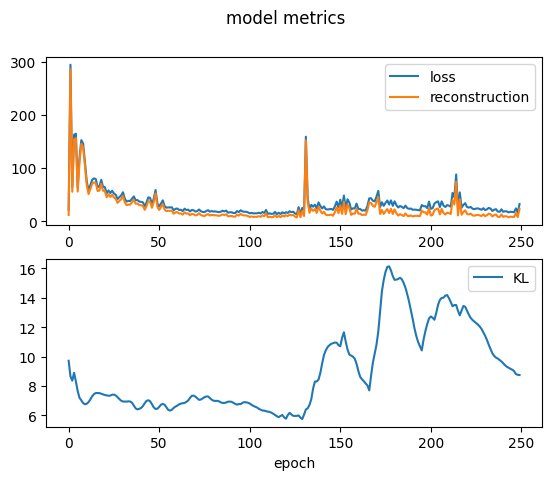

In [ ]:
fig, axs = plt.subplots(2)
fig.suptitle('model metrics')
axs[0].plot(history1.history['loss'])
axs[0].plot(history1.history['reconstruction_loss'])
axs[0].legend(['loss', 'reconstruction'])
axs[1].plot(history1.history['kl_loss'])
axs[1].legend(['KL'])
plt.xlabel('epoch')

In [ ]:
vae2 = tsgm.models.cvae.BetaVAE(encoder, decoder)
vae2.compile(optimizer=keras.optimizers.Adam())

history2 = vae2.fit(timeseries_imputed_scaled, epochs=100, batch_size=16)




Text(0.5, 0, 'epoch')

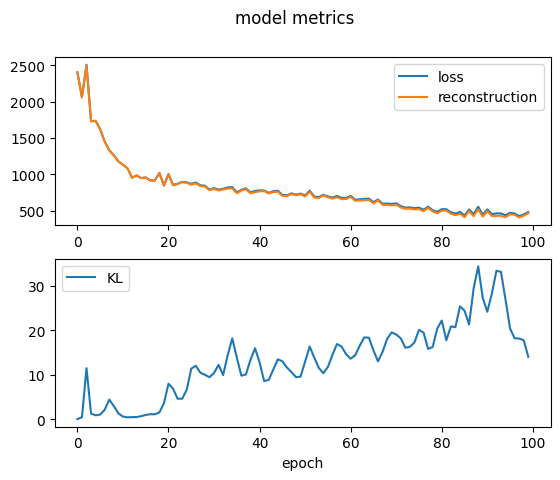

In [ ]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(2)
fig.suptitle('model metrics')
axs[0].plot(history2.history['loss'])
axs[0].plot(history2.history['reconstruction_loss'])
axs[0].legend(['loss', 'reconstruction'])
axs[1].plot(history2.history['kl_loss'])
axs[1].legend(['KL'])
plt.xlabel('epoch')

In [ ]:
vae3 = tsgm.models.cvae.BetaVAE(encoder, decoder)
vae3.compile(optimizer=keras.optimizers.Adam())

vae3.fit(timeseries_droppedna_scaled, epochs=200, batch_size=16)

Epoch 1/200
1/1 [==============================] - 7s 7s/step - loss: 5324.9634 - reconstruction_loss: 5324.7827 - kl_loss: 0.1803
Epoch 2/200
1/1 [==============================] - 0s 73ms/step - loss: 5324.7842 - reconstruction_loss: 5324.7754 - kl_loss: 0.0086
Epoch 3/200
1/1 [==============================] - 0s 73ms/step - loss: 5322.0796 - reconstruction_loss: 5322.0767 - kl_loss: 0.0031
Epoch 4/200
1/1 [==============================] - 0s 72ms/step - loss: 5321.1992 - reconstruction_loss: 5321.1963 - kl_loss: 0.0027
Epoch 5/200
1/1 [==============================] - 0s 74ms/step - loss: 5321.2720 - reconstruction_loss: 5321.2686 - kl_loss: 0.0031
Epoch 6/200
1/1 [==============================] - 0s 72ms/step - loss: 5321.2612 - reconstruction_loss: 5321.2573 - kl_loss: 0.0034
Epoch 7/200
1/1 [==============================] - 0s 71ms/step - loss: 5321.0439 - reconstruction_loss: 5321.0415 - kl_loss: 0.0027
Epoch 8/200
1/1 [==============================] - 0s 71ms/step - loss:

In [ ]:
vae.save_weights('./state_files/vae_model_tsscaler')

In [ ]:
new_data = vae.generate(100)

In [ ]:
with np.printoptions(threshold=20000, linewidth=10000, suppress = True):
  print(new_data)

In [ ]:
joblib.dump(new_data, './state_files/vae_data_ndarray.data')

['./state_files/vae_data_ndarray.data']

## GAN approach


In [ ]:
# I used all the default settings from the tutorial (except for seq_len and n_features). The GAN is performing very poorly. Consider looking at what optimizations can be done.

GAN_model = tsgm.models.timeGAN.TimeGAN(
    seq_len=500,
    module="gru",
    hidden_dim=24,
    n_features=7,
    n_layers=3,
    batch_size=256,
    gamma=1.0,
)
# .compile() sets all optimizers to Adam by default
GAN_model.compile()



In [ ]:
GAN_model.fit(
    data=timeseries_imputed_scaled,
    epochs=100,
)

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(256, 500, 7)]           0         
                                                                 
 Embedder (Sequential)       (256, 500, 24)            10176     
                                                                 
 Recovery (Sequential)       (256, 500, 7)             10975     
                                                                 
Total params: 21151 (82.62 KB)
Trainable params: 21151 (82.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "AdversarialSupervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomNoise (InputLayer)    [(256, 500, 7)]           0         
                                                      

INFO:models:Start Embedding Network Training
Autoencoder - training: 100%|██████████| 100/100 [03:08<00:00,  1.88s/it]
INFO:models:Finished Embedding Network Training
INFO:models:Start Training with Supervised Loss Only
Adversarial Supervised - training: 100%|██████████| 100/100 [02:12<00:00,  1.33s/it]
INFO:models:Finished Training with Supervised Loss Only
INFO:models:Start Joint Training
GAN with embedding - training: 100%|██████████| 100/100 [1:36:04<00:00, 57.65s/it]
INFO:models:Finished Joint Training


In [ ]:
gan_data = GAN_model.generate(n_samples=100)

Synthetic data generation: 100%|██████████| 1/1 [00:12<00:00, 12.03s/it]


In [ ]:
gan_data.shape

(100, 500, 7)

In [ ]:
joblib.dump(gan_data, './state_files/gan_data_ndarray.data')

['./state_files/gan_data_ndarray.data']

In [ ]:
loaded_data = joblib.load('./state_files/gan_data_ndarray.data')

In [ ]:
loaded_data